# Implementation of Off-Policy MC Control with Weighted Importance Sampling

follows denny britz's RL tutorial: https://github.com/dennybritz/reinforcement-learning

Ted Moskovitz, 2018

In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        nA = len(Q[observation])
        greedy_A = np.argmax(Q[observation])
        
        # greedy policy
        action_probs = np.zeros(nA) 
        action_probs[greedy_A] = 1.0
        return action_probs
        
    return policy_fn

In [6]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # A dictionary that maps state -> action importance weights
    C = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for i_episode in range(1,num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print ('\rEpisode {}/{}'.format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        # generate an episode with the behavior policy
        state = env.reset()
        episode = []
        for t in range(100):
            action_probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            # take a step in env
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done: break;
            state = next_state
        
        # evaluate and generate target policy
        W = 1.0
        G = 0.0
        for s,a,r in episode[::-1]:
            G = discount_factor * G + r
            C[s][a] += W
            Q[s][a] += (W / C[s][a]) * (G - Q[s][a])
            # update target policy
            target_policy = create_greedy_policy(Q)
            if a != np.argmax(target_policy(s)):
                break
            # update weight ratios of different policies
            W *= 1 / behavior_policy(s)[a]   
        
    return Q, target_policy

In [7]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000

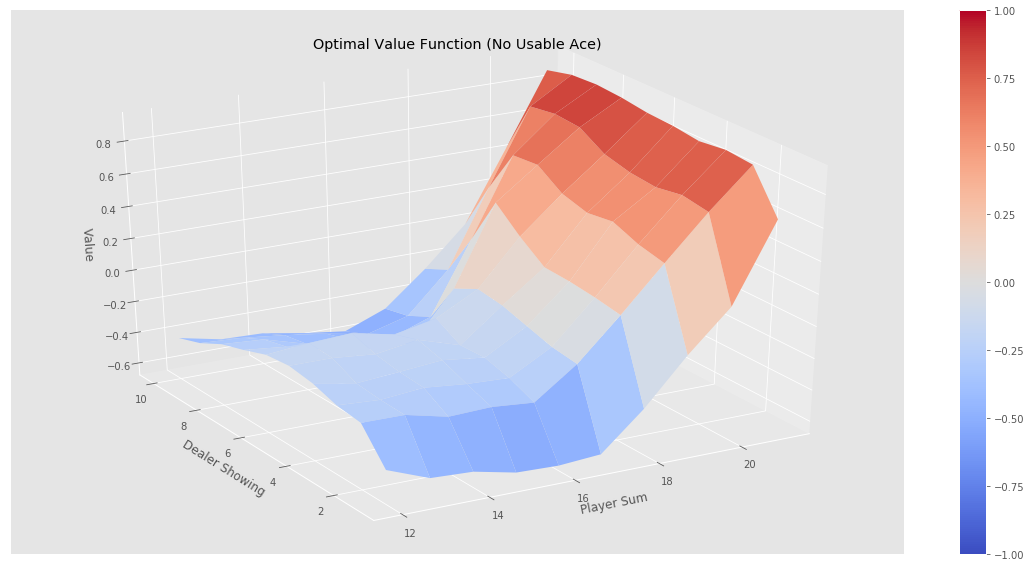

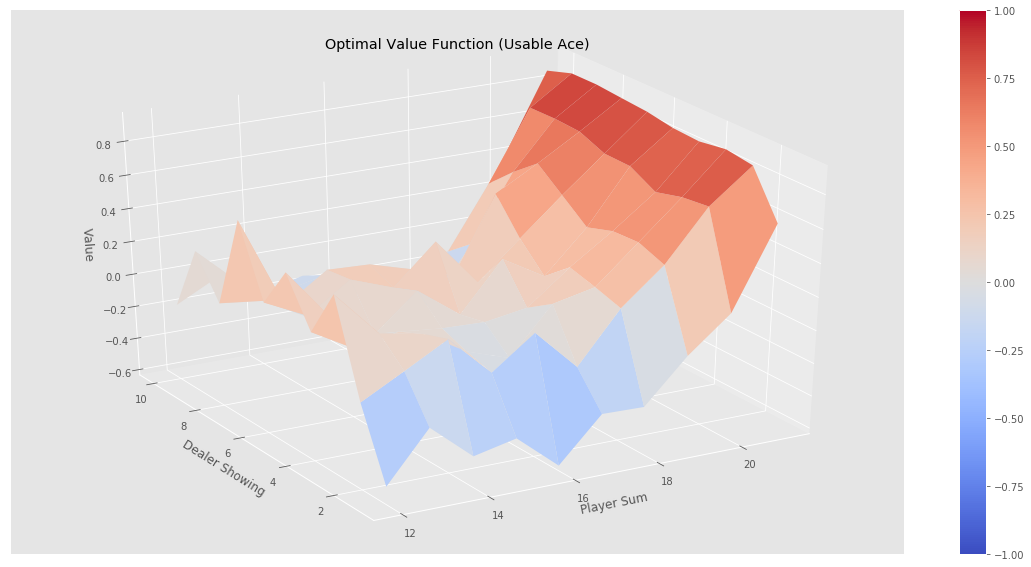

In [8]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")